In [3]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler  # for scaling
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

from string import punctuation
from nltk.corpus import stopwords

from scipy.stats import uniform

from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import joblib

### Load the training data
Let's load our training data, take a look at a few rows and one of the review texts in detail.

In [4]:
data = pd.read_csv("./data/amazon_musical_reviews/Musical_instruments_reviews.csv")
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [5]:
data["reviewText"].iloc[1]

"The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]"

### Preprocessing
Time to process our texts! Basically, we'll:
- Remove the English stopwords
- Remove punctuations
- Drop unused columns

In [6]:
def threshold_ratings(data):
    def threshold_overall_rating(rating):
        return 0 if int(rating)<=3 else 1
    data["overall"] = data["overall"].apply(threshold_overall_rating)

def remove_stopwords_punctuation(data):
    data["review"] = data["reviewText"] + data["summary"]

    puncs = list(punctuation)
    stops = stopwords.words("english")

    def remove_stopwords_in_str(input_str):
        filtered = [char for char in str(input_str).split() if char not in stops]
        return ' '.join(filtered)

    def remove_punc_in_str(input_str):
        filtered = [char for char in input_str if char not in puncs]
        return ''.join(filtered)

    def remove_stopwords_in_series(input_series):
        text_clean = []
        for i in range(len(input_series)):
            text_clean.append(remove_stopwords_in_str(input_series[i]))
        return text_clean

    def remove_punc_in_series(input_series):
        text_clean = []
        for i in range(len(input_series)):
            text_clean.append(remove_punc_in_str(input_series[i]))
        return text_clean

    data["review"] = remove_stopwords_in_series(data["review"].str.lower())
    data["review"] = remove_punc_in_series(data["review"].str.lower())

def drop_unused_colums(data):
    data.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime', "reviewText", "summary"], axis=1, inplace=True)

def preprocess_reviews(data):
    remove_stopwords_punctuation(data)
    threshold_ratings(data)
    drop_unused_colums(data)

In [7]:
preprocess_reviews(data)
data.head()

,overall,review
0,1,much write here exactly supposed to filters po...
1,1,product exactly quite affordablei realized dou...
2,1,primary job device block breath would otherwis...
3,1,nice windscreen protects mxl mic prevents pops...
4,1,pop filter great looks performs like studio fi...


### Split our training and test sets

In [8]:
rand_seed = 42
X = data["review"]
y = data["overall"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

In [9]:
params = {"max_depth": range(9,12), "min_child_weight": range(5,8)}
rand_search_cv = RandomizedSearchCV(XGBClassifier(), param_distributions=params, n_iter=5)

model  = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', rand_search_cv)
])
model.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model',
                 RandomizedSearchCV(estimator=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            learning_rate=None,
                                                            max_delta_step=None,
                 

In [10]:
predictions = model.predict(X_test)
acc = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {round(acc * 100, 2)}")

Model Accuracy: 89.19


In [11]:
import shap
import xgboost
shap.initjs()
clf = model.named_steps['model'].best_estimator_
explainer = shap.TreeExplainer(clf)

transformed_x_test = model["vect"].transform(X_test)
transformed_x_test = model["tfidf"].transform(transformed_x_test)

shap_values = explainer.shap_values(transformed_x_test)
transformed_x_test_array = transformed_x_test.toarray() # we need to pass a dense version for the plotting functions

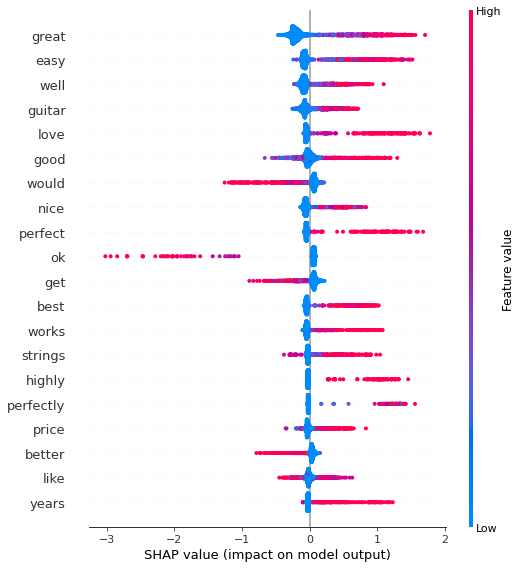

In [12]:
shap.summary_plot(shap_values, transformed_x_test_array, feature_names=model["vect"].get_feature_names())

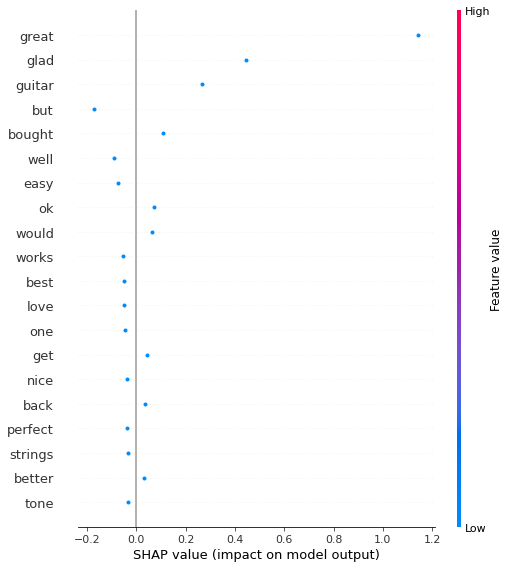

In [13]:
X_single_predict = pd.Series(["I am glad I bought this guitar, it is great! I then regretted my decision but still..."])
transformed_x_singlepredict = model["vect"].transform(X_single_predict)
transformed_x_singlepredict = model["tfidf"].transform(transformed_x_singlepredict)

shap_values = explainer.shap_values(transformed_x_singlepredict)
transformed_x_singlepredict_array = transformed_x_singlepredict.toarray() # we need to pass a dense version for the plotting functions

shap.summary_plot(shap_values, transformed_x_singlepredict_array, feature_names=model["vect"].get_feature_names())



In [14]:
shap.force_plot(
    explainer.expected_value, shap_values[0,:], transformed_x_singlepredict_array[0,:],
    feature_names=model["vect"].get_feature_names()
)
